In [1]:
# This notebook classifies movie reviews as positive or negative using the text of the review. 

from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tf-nightly-2.0-preview
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

     |████████████████████████████████| 87.5MB 3.3MB/s 
     |████████████████████████████████| 430kB 40.5MB/s 
     |████████████████████████████████| 61kB 27.7MB/s 
     |████████████████████████████████| 3.1MB 32.6MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
2.0.0-dev20190511


In [2]:
# Download the IMDB dataset
# reviews(sequence of words) have been converted to sequences of integers,
# where each integer represents a specific word in dictionary

imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# num_words keeps the top 10,000 most frequently occuring words in the training data.
# The rare words are discarded to keep the size of the data manageable.


17465344/17464789 [==============================] - 0s 0us/step


In [3]:
## Explore data

# Each example is an array of integers representing the words of the movie review. 
# Each label is an integer value of either 0 or 1, where 0 is a negative review, 
# and 1 is a positive review.

print('Training entries: {}, labels: {}'.format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
# The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary.
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
# Movie reviews may be different lengths.
# Since inputs to a neural network must be the same length, we'll need to resolve this later.

len(train_data[0]), len(train_data[1])

(218, 189)

In [0]:
# Convert the integers back to words
# It may be useful to know how to convert integers back to text. 

# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = { k : (v + 3) for k, v in word_index.items() }
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2 # unknown
word_index['<UNUSED>'] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [0]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [14]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [0]:
## Prepare the data
# The reviews—the arrays of integers
# - must be converted to tensors before fed into the neural network.

# This conversion can be done a couple of ways:

# 1. Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding.
# requiring a num_words * num_reviews size matrix.

# 2. Alternatively, we can pad the arrays so they all have the same length, 
# then create an integer tensor of shape max_length * num_reviews.

# Use second approach

train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index['<PAD>'],
                                                      padding='post',
                                                      maxlen=256)

In [19]:
len(train_data[0]), len(test_data[0])

(256, 256)

In [20]:
# inspect the firest review
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [23]:
## Build the model

# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
## Loss function and optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
## Create a validation set
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [26]:
## Train the model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 63us/sample - loss: 0.6919 - accuracy: 0.6095 - val_loss: 0.6900 - val_accuracy: 0.6880
Epoch 2/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6863 - accuracy: 0.6997 - val_loss: 0.6818 - val_accuracy: 0.7311
Epoch 3/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6734 - accuracy: 0.7352 - val_loss: 0.6653 - val_accuracy: 0.7326
Epoch 4/40
15000/15000 [==============================] - 1s 46us/sample - loss: 0.6509 - accuracy: 0.7549 - val_loss: 0.6396 - val_accuracy: 0.7373
Epoch 5/40
15000/15000 [==============================] - 1s 46us/sample - loss: 0.6182 - accuracy: 0.7817 - val_loss: 0.6054 - val_accuracy: 0.7756
Epoch 6/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.5773 - accuracy: 0.8072 - val_loss: 0.5659 - val_accuracy: 0.8084
Epoch 7/40
15000/15000 [==============================] 

In [27]:
## Evaluate the mode

results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 36us/sample - loss: 0.3315 - accuracy: 0.8718
[0.3314644498348236, 0.87176]


In [28]:
## Create a graph of accuracy and loss over time
# model.fit() returns a History object that contains a dictionary with everything that happened during training:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

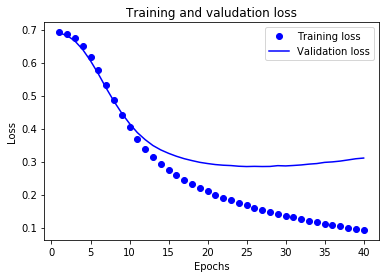

In [29]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and valudation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

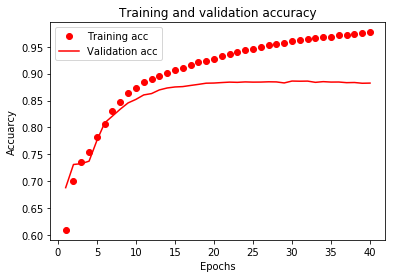

In [31]:
plt.clf() # Clear figure

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.legend()

plt.show()

In [0]:
# https://www.tensorflow.org/alpha/tutorials/keras/basic_text_classification